In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("baiskiki/garbage-dataset")

print("Path to dataset files:", path)
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Output streaming akan dipotong hingga 5000 baris terakhir.
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_2343.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_1321.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_1665.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_3967.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_3899.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_4888.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_585.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_995.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_423.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_3364.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_3192.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_2683.jpg
/kaggle/input/garbage-dataset/garbage-dataset/clothes/clothes_4173.jpg
/kaggle/input/garbage

In [6]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
# Libraries untuk pemrosesan data gambar
!pip install opencv-python
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
!pip install tensorflow
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import os
import shutil
import random

# Direktori asal dataset
source_dir = "/kaggle/input/garbage-dataset/garbage-dataset"
working_dir = "/kaggle/working/garbage-dataset"

# Pastikan direktori tujuan ada
os.makedirs(working_dir, exist_ok=True)

# Salin seluruh dataset ke `/kaggle/working/`
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    working_category_path = os.path.join(working_dir, category)

    if os.path.isdir(category_path):
        os.makedirs(working_category_path, exist_ok=True)

        for file in os.listdir(category_path):
            shutil.copy(os.path.join(category_path, file), os.path.join(working_category_path, file))

print("Dataset berhasil disalin ke working directory! 🚀")

Dataset berhasil disalin ke working directory! 🚀


In [8]:
# Direktori tujuan untuk split data
split_base_dir = "/kaggle/working/final-garbage-dataset"
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "validation")
test_dir = os.path.join(split_base_dir, "test")

# Buat direktori split jika belum ada
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Rasio pembagian dataset
split_ratio = {"train": 0.7, "validation": 0.15, "test": 0.15}

# Iterasi setiap kategori dalam working_dir
for category in os.listdir(working_dir):
    category_path = os.path.join(working_dir, category)

    if os.path.isdir(category_path):
        # Buat subfolder kategori di masing-masing train, val, test
        train_category_path = os.path.join(train_dir, category)
        val_category_path = os.path.join(val_dir, category)
        test_category_path = os.path.join(test_dir, category)

        for subdir in [train_category_path, val_category_path, test_category_path]:
            os.makedirs(subdir, exist_ok=True)

        # Dapatkan daftar file dalam kategori
        files = os.listdir(category_path)
        random.shuffle(files)

        # Hitung jumlah file untuk masing-masing set
        num_files = len(files)
        num_train = int(num_files * split_ratio["train"])
        num_val = int(num_files * split_ratio["validation"])
        num_test = num_files - num_train - num_val

        # Fungsi untuk menyalin file ke direktori tertentu
        def copy_files(file_list, destination):
            for file in file_list:
                shutil.copy(os.path.join(category_path, file), os.path.join(destination, file))

        # Pindahkan file ke masing-masing direktori
        copy_files(files[:num_train], train_category_path)
        copy_files(files[num_train:num_train + num_val], val_category_path)
        copy_files(files[num_train + num_val:], test_category_path)

print("Dataset berhasil disalin dan dibagi per kategori! 🚀")


Dataset berhasil disalin dan dibagi per kategori! 🚀


In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hapus semua info log selain error
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

# 1. Menyiapkan Data Generator
# Tentukan direktori dataset split
train_dir = "/kaggle/working/final-garbage-dataset/train"
val_dir   = "/kaggle/working/final-garbage-dataset/validation"
test_dir  = "/kaggle/working/final-garbage-dataset/test"

# Buat ImageDataGenerator untuk masing-masing dataset; rescale untuk normalisasi
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen   = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

# Flow dari direktori dengan target size 224x224 sesuai input shape model
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # Changed target_size to (224, 224)
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)
val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224), # Changed target_size to (224, 224)
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), # Changed target_size to (224, 224)
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Gunakan label yang dihasilkan oleh train_set. Misal, jika train_set.classes berisi label numerik
y_train = train_set.classes
classes = np.unique(y_train)

# compute_class_weight akan menghitung bobot supaya distribusi kelas menjadi seimbang
computed_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, computed_weights))
print("Computed Class Weights:", class_weight_dict)

# Definisikan model CNN yang lebih dalam dan teroptimasi
cnn_model = Sequential([
    # Blok 1
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), strides=(1,1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Blok 2
    Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1,1), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),

    # Blok 3
    Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1,1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Blok 4
    Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1,1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening
    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(classes), activation='softmax')
])

cnn_model.summary()

# 3. Compile Model
opt = Adam(learning_rate=0.00005)
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

# Setup EarlyStopping agar pelatihan berhenti jika val_accuracy tidak meningkat
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# 4. Melatih Model
num_epochs = 10
cnn_hist = cnn_model.fit(
    train_set,
    epochs=num_epochs,
    validation_data=val_set,
    verbose=2,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# 5. Menampilkan Hasil Akurasi
# Ambil akurasi tertinggi dari data training dan validasi dari history
final_train_acc = max(cnn_hist.history['accuracy'])
final_val_acc   = max(cnn_hist.history['val_accuracy'])
print("Training Accuracy: {:.4f}".format(final_train_acc))
print("Validation Accuracy: {:.4f}".format(final_val_acc))

# Evaluasi model pada test set
test_loss, test_acc = cnn_model.evaluate(test_set, steps=len(test_set), verbose=2)
print("Test Accuracy: {:.4f}".format(test_acc))

Found 9680 images belonging to 6 classes.
Found 2073 images belonging to 6 classes.
Found 2081 images belonging to 6 classes.
Computed Class Weights: {np.int32(0): np.float64(2.4444444444444446), np.int32(1): np.float64(2.314681970349115), np.int32(2): np.float64(1.2633777081701905), np.int32(3): np.float64(0.43276108726752505), np.int32(4): np.float64(0.7531901649548708), np.int32(5): np.float64(1.3718820861678005)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,247,238 (103.94 MB)

 Trainable params: 27,245,062 (103.93 MB)

 Non-trainable params: 2,176 (8.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
152/152 - 90s - 595ms/step - accuracy: 0.7031 - loss: 2.0035 - val_accuracy: 0.3854 - val_loss: 2.8930
Epoch 2/10
152/152 - 49s - 323ms/step - accuracy: 0.8769 - loss: 1.4574 - val_accuracy: 0.3739 - val_loss: 2.9059
Epoch 3/10
152/152 - 51s - 335ms/step - accuracy: 0.9468 - loss: 1.2678 - val_accuracy: 0.5084 - val_loss: 2.3882
Epoch 4/10
152/152 - 48s - 314ms/step - accuracy: 0.9742 - loss: 1.1750 - val_accuracy: 0.7820 - val_loss: 1.7071
Epoch 5/10
152/152 - 46s - 304ms/step - accuracy: 0.9856 - loss: 1.1334 - val_accuracy: 0.8427 - val_loss: 1.5729
Epoch 6/10
152/152 - 47s - 312ms/step - accuracy: 0.9913 - loss: 1.0962 - val_accuracy: 0.8490 - val_loss: 1.5612
Epoch 7/10
152/152 - 49s - 322ms/step - accuracy: 0.9909 - loss: 1.0701 - val_accuracy: 0.8374 - val_loss: 1.6411
Epoch 8/10
152/152 - 50s - 327ms/step - accuracy: 0.9959 - loss: 1.0461 - val_accuracy: 0.8041 - val_loss: 1.6195
Training Accuracy: 0.9959
Validation Accuracy: 0.8490
33/33 - 11s - 336ms/step - accurac

Visualisasi History Pelatihan Model:


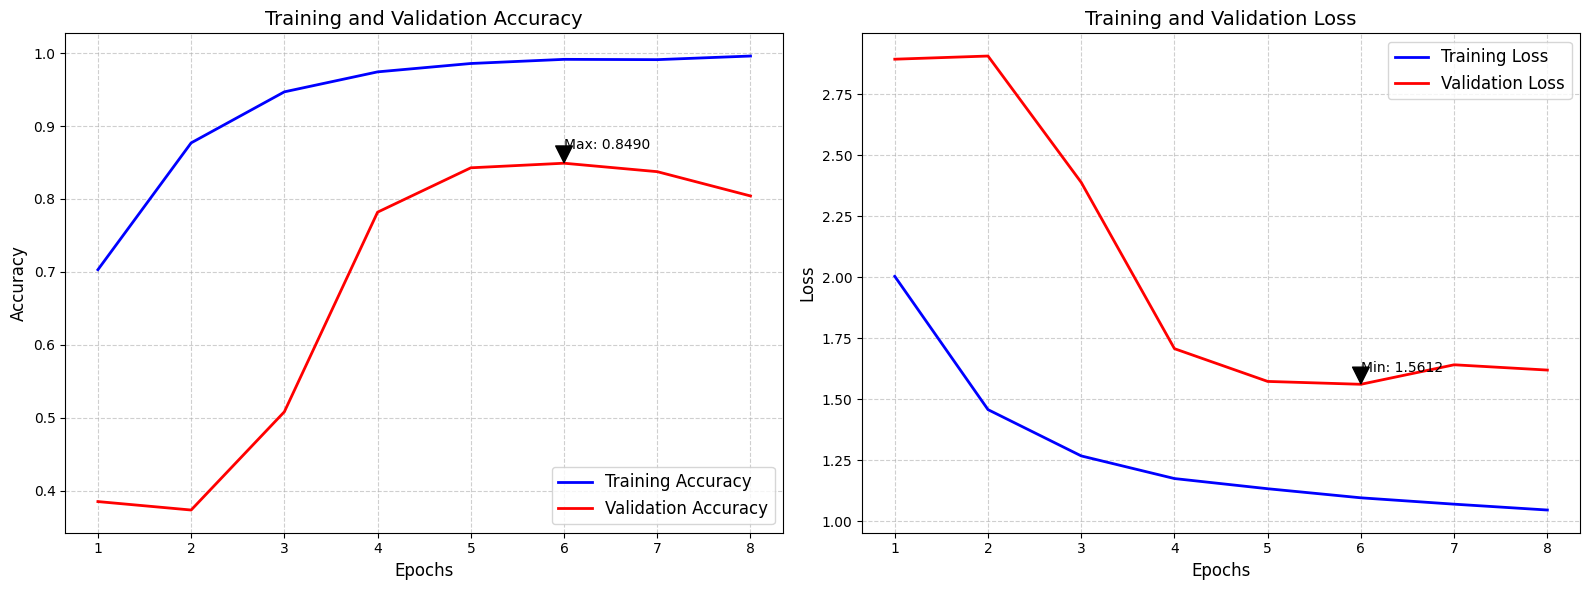


Evaluasi Model pada Data Test:
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.8306 - loss: 1.6183
Test Loss: 1.4548
Test Accuracy: 0.8765

Membuat Prediksi pada Test Set...
Kelas yang diprediksi: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'paper']

Classification Report:
              precision    recall  f1-score   support

     battery       0.90      0.69      0.78       143
  biological       0.85      0.80      0.82       151
   cardboard       0.92      0.80      0.85       275
     clothes       0.96      0.95      0.95       800
       glass       0.85      0.90      0.87       460
       paper       0.68      0.83      0.75       252

    accuracy                           0.88      2081
   macro avg       0.86      0.83      0.84      2081
weighted avg       0.88      0.88      0.88      2081


Confusion Matrix:
Confusion Matrix, without normalization


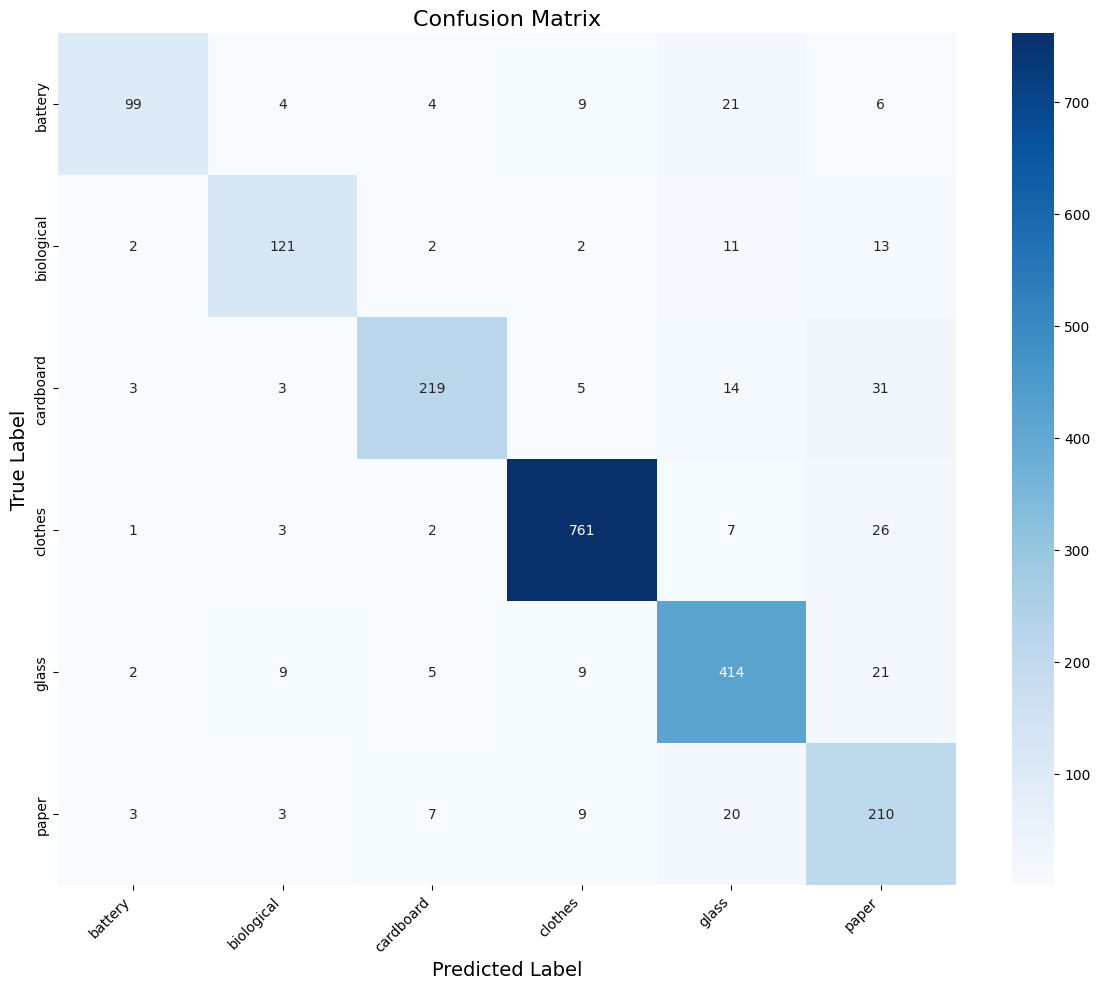

Normalized Confusion Matrix


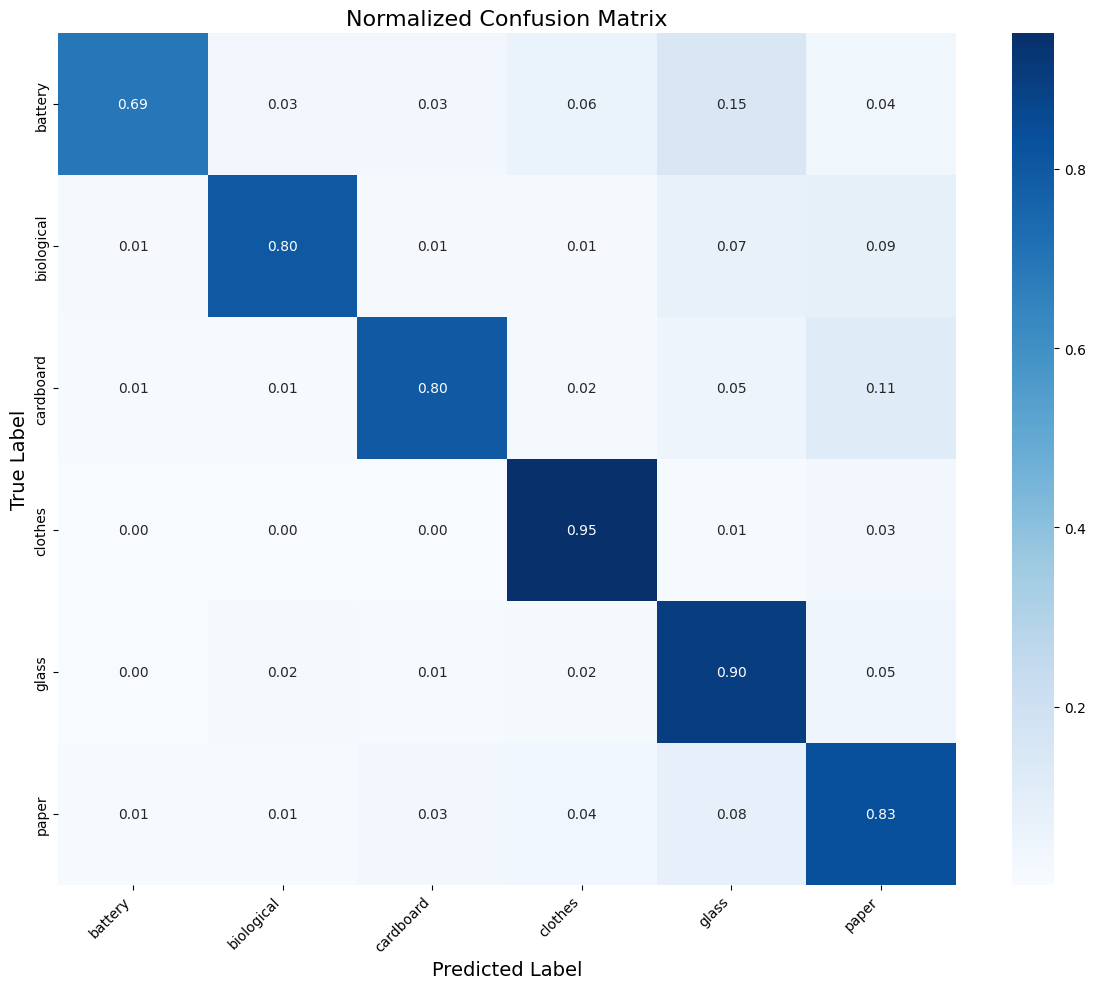


Akurasi per Kelas:


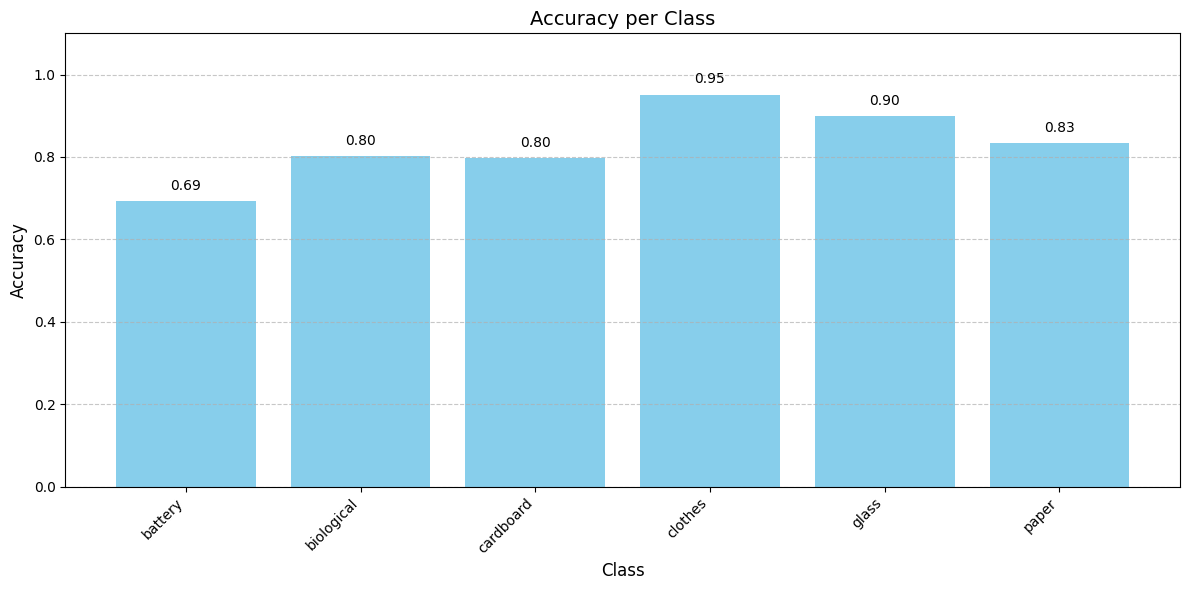


Menyimpan hasil evaluasi ke file...

Ringkasan Evaluasi Model:
Test Accuracy: 0.8765
Test Loss: 1.4548
Top 3 kelas dengan akurasi tertinggi:
- clothes: 0.9513
- glass: 0.9000
- paper: 0.8333

Kelas dengan akurasi terendah:
- battery: 0.6923


In [10]:
# Evaluasi dan Visualisasi Model Klasifikasi Sampah
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 1. Visualisasi History Pelatihan Model
def plot_training_history(history):
    # Mengambil nilai akurasi dan loss dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Menghitung jumlah epoch
    epochs = range(1, len(acc) + 1)

    # Membuat figure dengan 2 subplot
    plt.figure(figsize=(16, 6))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Menambahkan anotasi untuk nilai tertinggi
    max_val_acc_epoch = np.argmax(val_acc) + 1
    max_val_acc = max(val_acc)
    plt.annotate(f'Max: {max_val_acc:.4f}',
                 xy=(max_val_acc_epoch, max_val_acc),
                 xytext=(max_val_acc_epoch, max_val_acc+0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=10)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Menambahkan anotasi untuk nilai terendah
    min_val_loss_epoch = np.argmin(val_loss) + 1
    min_val_loss = min(val_loss)
    plt.annotate(f'Min: {min_val_loss:.4f}',
                xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch, min_val_loss+0.05),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)

    plt.tight_layout()
    plt.savefig('model_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 10))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)

    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Plot Sample Images with Predictions
def plot_sample_predictions(test_set, model, num_samples=16):
    # Dapatkan beberapa batch dari test set
    images, true_labels = next(test_set)

    # Prediksi kelas untuk batch tersebut
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    # Dapatkan label kategori (nama kelas)
    class_indices = test_set.class_indices
    category_names = {v: k for k, v in class_indices.items()}

    # Pilih sampel secara acak atau gunakan beberapa sampel pertama
    num_samples = min(num_samples, len(images))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)

    # Plot sampel
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i < num_samples:
            # Plot gambar
            img = images[idx]
            axes[i].imshow(img)

            # Tentukan warna berdasarkan prediksi benar/salah
            color = 'green' if pred_labels[idx] == true_labels[idx] else 'red'

            # Tambahkan label
            title = f"True: {category_names[true_labels[idx]]}\nPred: {category_names[pred_labels[idx]]}"
            axes[i].set_title(title, color=color)
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. Plot Per-Class Accuracy
def plot_per_class_accuracy(y_true, y_pred, class_names):
    # Hitung akurasi per kelas
    per_class_acc = []

    for i in range(len(class_names)):
        # Pilih sampel dengan kelas i
        mask = (y_true == i)
        if np.sum(mask) > 0:
            # Hitung akurasi untuk kelas ini
            class_acc = np.mean(y_pred[mask] == i)
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0)

    # Plot akurasi per kelas
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(class_names)), per_class_acc, color='skyblue')

    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy per Class', fontsize=14)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------------------------------------------------------
# Jalankan Evaluasi dan Visualisasi
# -------------------------------------------------------------------------

# Visualisasi history pelatihan
print("Visualisasi History Pelatihan Model:")
plot_training_history(cnn_hist)

# Evaluasi model pada test set
print("\nEvaluasi Model pada Data Test:")
test_loss, test_acc = cnn_model.evaluate(test_set, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Prediksi pada test set
print("\nMembuat Prediksi pada Test Set...")
# Karena test_set adalah generator, kita perlu mengumpulkan semua prediksi batch by batch
y_pred_prob = []
y_true = []

# Reset generator
test_set.reset()

# Prediksi untuk setiap batch
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    pred_batch = cnn_model.predict(x_batch, verbose=0)
    y_pred_prob.extend(pred_batch)
    y_true.extend(y_batch)

# Konversi ke array numpy
y_pred_prob = np.array(y_pred_prob)
y_true = np.array(y_true)

# Konversi one-hot encoding ke label kelas
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_true, axis=1)

# Dapatkan nama kelas
class_indices = test_set.class_indices
class_names = list(class_indices.keys())
print(f"Kelas yang diprediksi: {class_names}")

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=class_names, normalize=False, title='Confusion Matrix')
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# Plot per-class accuracy
print("\nAkurasi per Kelas:")
plot_per_class_accuracy(y_true, y_pred, class_names)


# Simpan model hasil evaluasi
print("\nMenyimpan hasil evaluasi ke file...")
evaluation_results = {
    "test_accuracy": test_acc,
    "test_loss": test_loss,
    "per_class_accuracy": dict(zip(class_names, [np.mean(y_pred[y_true == i] == i) for i in range(len(class_names))])),
}

# Cetak ringkasan evaluasi
print("\nRingkasan Evaluasi Model:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("Top 3 kelas dengan akurasi tertinggi:")
per_class_acc = [np.mean(y_pred[y_true == i] == i) for i in range(len(class_names))]
top_classes = sorted(zip(class_names, per_class_acc), key=lambda x: x[1], reverse=True)[:3]
for cls, acc in top_classes:
    print(f"- {cls}: {acc:.4f}")

print("\nKelas dengan akurasi terendah:")
worst_class = min(zip(class_names, per_class_acc), key=lambda x: x[1])
print(f"- {worst_class[0]}: {worst_class[1]:.4f}")

In [11]:
# Import library yang diperlukan
!pip install tensorflowjs
import os
import tensorflow as tf
import tensorflowjs as tfjs


# Buat direktori utama jika belum ada
os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("tflite", exist_ok=True)
os.makedirs("saved_model", exist_ok=True)

# Asumsikan 'model' adalah variabel yang menyimpan model yang telah Anda latih
# Jika model Anda disimpan dengan nama variabel lain, silakan ganti 'model' dengan nama variabel tersebut

# 1. Menyimpan model dalam format SavedModel
saved_model_path = "./saved_model"
tf.saved_model.save(cnn_model, saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

# 2. Menyimpan model dalam format TF-Lite
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = "./tflite/model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Jika model Anda adalah model klasifikasi, buat file label.txt
# Ganti dengan label yang sesuai dengan kelas-kelas dalam model Anda
labels = ["Label 0", "Label 1", "Label 2", "Label 3", "Label 4",
          "Label 5"]
with open("./tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

print(f"Model berhasil disimpan dalam format TF-Lite di: {tflite_model_path}")

# 3. Menyimpan model dalam format TensorFlow.js
tfjs_model_path = "./tfjs_model"
tfjs.converters.save_keras_model(cnn_model, tfjs_model_path)
print(f"Model berhasil disimpan dalam format TensorFlow.js di: {tfjs_model_path}")

# Tampilkan struktur direktori
print("\nStruktur file yang dihasilkan:")
print("""
├──tfjs_model
│  ├──group1-shard1of1.bin
│  └──model.json
├──tflite
│  ├──model.tflite
│  └──label.txt
└──saved_model
   ├──saved_model.pb
   └──variables
""")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Model berhasil disimpan dalam format SavedModel di: ./saved_model
Saved artifact at '/tmp/tmp5cmabwrh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134271605312784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605313744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605317200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605314896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605315856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605312976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605316624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605317584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605317392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134271605318160: T

Model berhasil disimpan dalam format TF-Lite di: ./tflite/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TensorFlow.js di: ./tfjs_model

Struktur file yang dihasilkan:

├──tfjs_model
│  ├──group1-shard1of1.bin
│  └──model.json
├──tflite
│  ├──model.tflite
│  └──label.txt
└──saved_model
   ├──saved_model.pb
   └──variables



In [14]:
!pip install keras-tuner
import keras_tuner as kt # Note the change from kerastuner to keras_tuner
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    # Contoh: men-tune jumlah Conv blocks (2–4)
    for i in range(hp.Int('conv_blocks', 2, 4, default=3)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            input_shape=(224,224,3) if i==0 else None
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D())
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_dense', 0.3, 0.6, step=0.1)))
    model.add(Dense(len(classes), activation='softmax'))

    # Tune learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,            # jumlah kombinasi hyperparametr yang diuji
    executions_per_trial=1,   # berapa kali setiap konfigurasi dilatih
    directory='my_tuner',     # folder hasil tuning
    project_name='garbage_cnn'
)

tuner.search(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)

# The following line refers to a function `test_all_model_formats` which is not defined in the provided code.
# It is likely that this function was intended to be defined elsewhere or is part of a separate script.
# For the code to run without error, this line needs to be removed or the function needs to be defined.
# img_path = "path_ke_gambar_uji.jpg"  # Sesuaikan dengan path gambar yang ingin diuji
# test_results = test_all_model_formats(img_path, class_names)
# print(test_results)

Trial 10 Complete [00h 03m 18s]
val_accuracy: 0.4471780061721802

Best val_accuracy So Far: 0.7081524133682251
Total elapsed time: 01h 01m 45s
{'conv_blocks': 3, 'filters_0': 32, 'dropout_0': 0.4, 'filters_1': 64, 'dropout_1': 0.2, 'filters_2': 64, 'dropout_2': 0.30000000000000004, 'dense_units': 192, 'dropout_dense': 0.3, 'learning_rate': 0.001}


OPTIONAL

Daftar Kelas: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'paper']
Melakukan Prediksi pada: /kaggle/working/final-garbage-dataset/test/glass/glass_4327.jpg


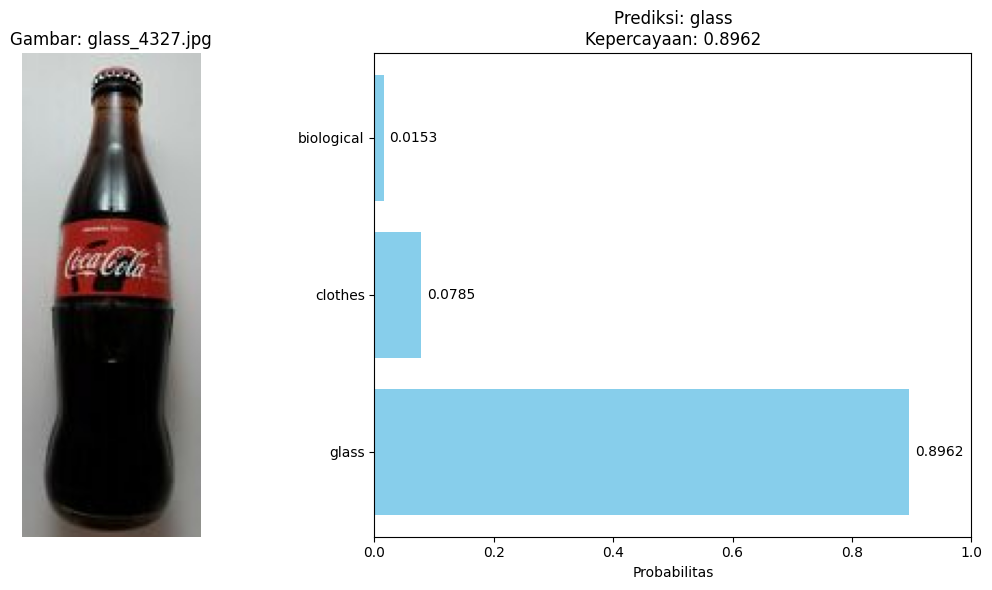

Hasil Prediksi untuk glass_4327.jpg:
Kelas Prediksi: glass
Kepercayaan: 0.8962
Waktu Inferensi: 156.41 ms

Top 3 Prediksi:
- glass: 0.8962
- clothes: 0.0785
- biological: 0.0153

BATCH PREDICTION PADA BEBERAPA GAMBAR:


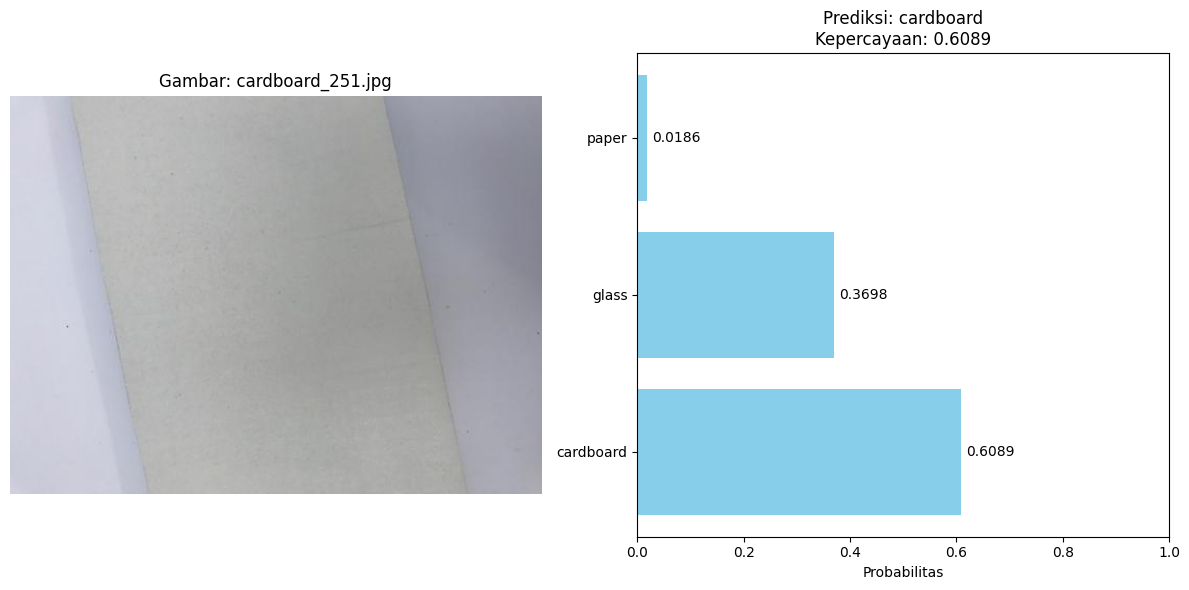

Hasil Prediksi untuk cardboard_251.jpg:
Kelas Prediksi: cardboard
Kepercayaan: 0.6089
Waktu Inferensi: 72.59 ms

Top 3 Prediksi:
- cardboard: 0.6089
- glass: 0.3698
- paper: 0.0186
--------------------------------------------------


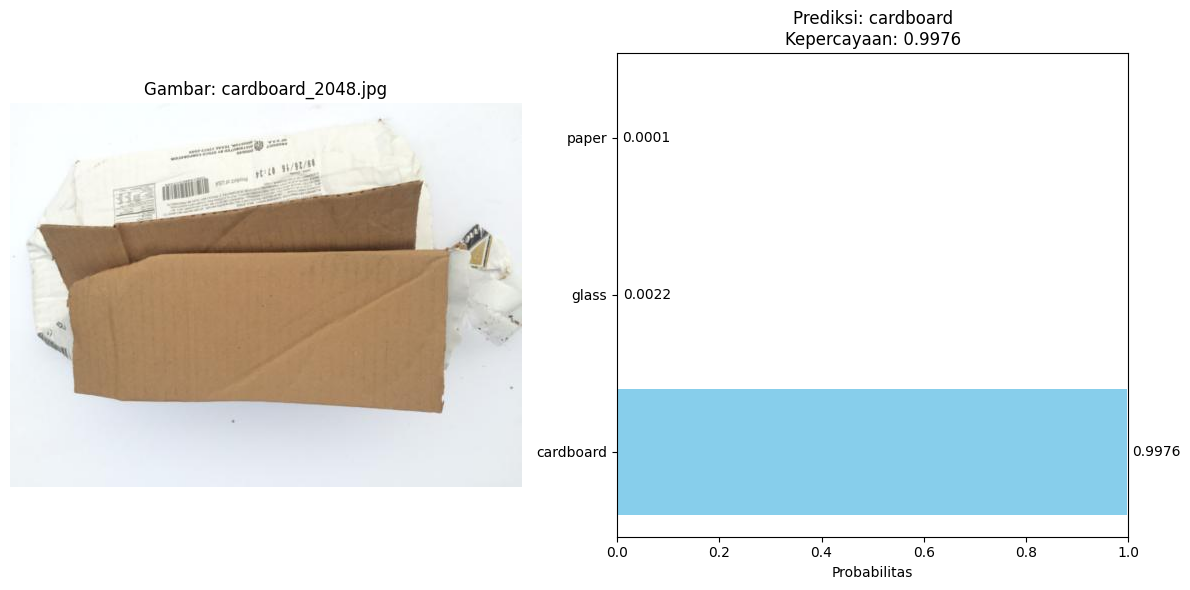

Hasil Prediksi untuk cardboard_2048.jpg:
Kelas Prediksi: cardboard
Kepercayaan: 0.9976
Waktu Inferensi: 157.01 ms

Top 3 Prediksi:
- cardboard: 0.9976
- glass: 0.0022
- paper: 0.0001
--------------------------------------------------


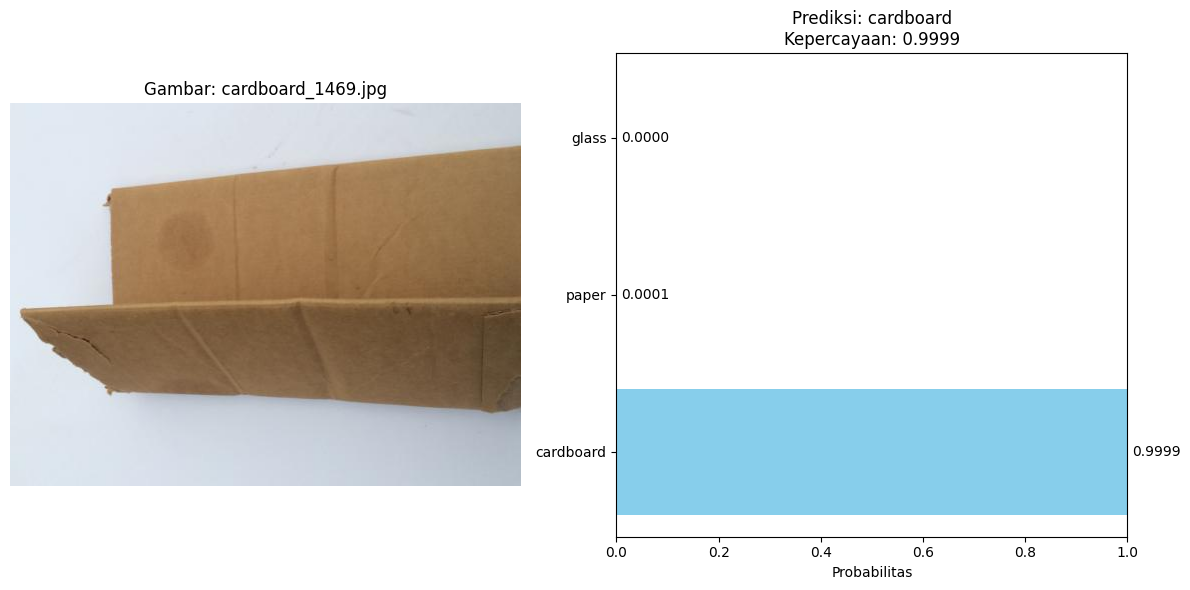

Hasil Prediksi untuk cardboard_1469.jpg:
Kelas Prediksi: cardboard
Kepercayaan: 0.9999
Waktu Inferensi: 142.61 ms

Top 3 Prediksi:
- cardboard: 0.9999
- paper: 0.0001
- glass: 0.0000
--------------------------------------------------
Error: File tidak ditemukan di /kaggle/working/final-garbage-dataset/test/paper/paper_1014.jpg
Mencoba mencari file 'paper_1014.jpg' di direktori test/paper...
Direktori /kaggle/working/final-garbage-dataset/test/paper ditemukan. Listing isinya:
['paper_2462.jpg', 'paper_992.jpg', 'paper_1234.jpg', 'paper_2371.jpg', 'paper_1460.jpg', 'paper_1478.jpg', 'paper_2664.jpg', 'paper_2567.jpg', 'paper_977.jpg', 'paper_1455.jpg', 'paper_2828.jpg', 'paper_1521.jpg', 'paper_2479.jpg', 'paper_1152.jpg', 'paper_1640.jpg', 'paper_1356.jpg', 'paper_1221.jpg', 'paper_2765.jpg', 'paper_1208.jpg', 'paper_720.jpg', 'paper_2347.jpg', 'paper_1669.jpg', 'paper_693.jpg', 'paper_2840.jpg', 'paper_468.jpg', 'paper_1020.jpg', 'paper_813.jpg', 'paper_1675.jpg', 'paper_3229.jpg', 'pa

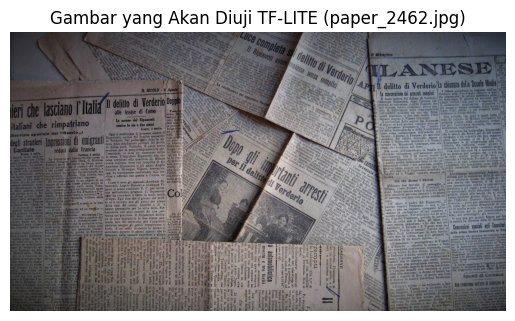


2. Inferensi dengan TF-Lite:
Error pada TF-Lite: Could not open '/kaggle/working/tflite/model.tflite'.
{}


In [16]:
# Import library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
from PIL import Image
import random
from tensorflow.keras.models import load_model
import time

# Fungsi untuk melakukan inferensi pada gambar tunggal
def predict_image(img_path, model, class_names):
    # Load gambar
    img = image.load_img(img_path, target_size=(224, 224))

    # Konversi gambar ke array
    img_array = image.img_to_array(img)

    # Normalisasi
    img_array = img_array / 255.0

    # Expand dimensi untuk batch
    img_array = tf.expand_dims(img_array, 0)

    # Prediksi
    start_time = time.time()
    predictions = model.predict(img_array, verbose=0)
    end_time = time.time()

    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_class = tf.argmax(predictions[0]).numpy()
    confidence = float(predictions[0][predicted_class])

    # Hitung waktu inferensi
    inference_time = (end_time - start_time) * 1000  # konversi ke ms

    return {
        'class_id': predicted_class,
        'class_name': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': predictions[0].tolist(),
        'inference_time': inference_time
    }

# Fungsi untuk visualisasi hasil prediksi
def visualize_prediction(img_path, prediction_result, class_names):
    # Load gambar
    img = Image.open(img_path)

    # Plot gambar dan prediksi
    plt.figure(figsize=(12, 6))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {os.path.basename(img_path)}")
    plt.axis('off')

    # Hasil prediksi
    plt.subplot(1, 2, 2)

    # Ambil top 3 prediksi
    probs = prediction_result['probabilities']
    top_indices = np.argsort(probs)[-3:][::-1]
    top_probs = [probs[i] for i in top_indices]
    top_classes = [class_names[i] for i in top_indices]

    # Plot bar chart
    bars = plt.barh(top_classes, top_probs, color='skyblue')
    plt.xlim(0, 1.0)
    plt.title(f"Prediksi: {prediction_result['class_name']}\nKepercayaan: {prediction_result['confidence']:.4f}")

    # Tambahkan nilai di akhir bar
    for bar, prob in zip(bars, top_probs):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{prob:.4f}',
                va='center', fontsize=10)

    plt.xlabel('Probabilitas')
    plt.tight_layout()
    plt.show()

    # Tampilkan hasil detail
    print(f"Hasil Prediksi untuk {os.path.basename(img_path)}:")
    print(f"Kelas Prediksi: {prediction_result['class_name']}")
    print(f"Kepercayaan: {prediction_result['confidence']:.4f}")
    print(f"Waktu Inferensi: {prediction_result['inference_time']:.2f} ms")
    print("\nTop 3 Prediksi:")
    for cls, prob in zip(top_classes, top_probs):
        print(f"- {cls}: {prob:.4f}")

# Fungsi untuk melakukan batch inferensi pada beberapa gambar
def predict_batch(test_dir, model, class_names, num_samples=5):
    results = []

    # Dapatkan semua path gambar dari direktori test
    all_imgs = []
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_imgs.append(os.path.join(root, file))

    # Pilih sampel acak
    if len(all_imgs) > num_samples:
        selected_imgs = random.sample(all_imgs, num_samples)
    else:
        selected_imgs = all_imgs

    # Lakukan prediksi untuk setiap gambar
    for img_path in selected_imgs:
        result = predict_image(img_path, model, class_names)
        results.append({
            'path': img_path,
            'prediction': result
        })

        # Visualisasikan hasilnya
        visualize_prediction(img_path, result, class_names)
        print("-" * 50)

    return results

# Fungsi untuk menguji model F-Lite
def test_all_model_formats(img_path, class_names):
    results = {}

    # 1. Inferensi dengan TF-Lite
    print("\n2. Inferensi dengan TF-Lite:")
    try:
        # Load TFLite model
        interpreter = tf.lite.Interpreter(model_path="/kaggle/working/tflite/model.tflite")
        interpreter.allocate_tensors()

        # Get input/output tensors
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Load gambar
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

        # Inferensi
        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        tflite_results = interpreter.get_tensor(output_details[0]['index'])
        end_time = time.time()

        # Dapatkan prediksi
        tflite_pred_class = np.argmax(tflite_results[0])
        tflite_confidence = float(tflite_results[0][tflite_pred_class])
        tflite_time = (end_time - start_time) * 1000  # ms

        results['tflite'] = {
            'class_id': int(tflite_pred_class),
            'class_name': class_names[tflite_pred_class],
            'confidence': tflite_confidence,
            'inference_time': tflite_time
        }

        print(f"TFLite Prediksi: {class_names[tflite_pred_class]}")
        print(f"Kepercayaan: {tflite_confidence:.4f}")
        print(f"Waktu Inferensi: {tflite_time:.2f} ms")
    except Exception as e:
        print(f"Error pada TF-Lite: {e}")

    return results

# -------------- PENGGUNAAN --------------

# Dapatkan nama kelas dari generator data
class_indices = test_set.class_indices
class_names = list(class_indices.keys())
print(f"Daftar Kelas: {class_names}")

# Load model yang sudah dilatih (model asli)
# Catatan: Jika model sudah tersedia di variabel cnn_model, tidak perlu load ulang
model = cnn_model

# METODE 1: Prediksi pada satu gambar
# Pilih gambar dari direktori train
test_path = "/kaggle/working/final-garbage-dataset/test"  # Sesuaikan dengan path direktori train
all_test_files = []
for root, _, files in os.walk(test_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_test_files.append(os.path.join(root, file))

# Pilih satu gambar secara acak
if all_test_files:
    random_img = random.choice(all_test_files)
    print(f"Melakukan Prediksi pada: {random_img}")

    # Prediksi dan visualisasi
    prediction = predict_image(random_img, model, class_names)
    visualize_prediction(random_img, prediction, class_names)
else:
    print("Tidak ada gambar test ditemukan.")

# METODE 2: Batch Prediction pada beberapa gambar
print("\n" + "="*50)
print("BATCH PREDICTION PADA BEBERAPA GAMBAR:")
print("="*50)
batch_results = predict_batch(test_path, model, class_names, num_samples=3)

# --- Diagnosa dan perbaikan untuk error FileNotFoundError ---
img_path = "/kaggle/working/final-garbage-dataset/test/paper/paper_1014.jpg"  # Sesuaikan dengan path gambar yang ingin diuji

# Cek apakah file ada
if os.path.exists(img_path):
    print(f"File {img_path} ditemukan.")

    # Load gambar dan tampilkan
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar yang Akan Diuji TF-LITE")
    plt.show()

    # Lakukan pengujian TFLite
    test_results = test_all_model_formats(img_path, class_names)
    print(test_results)

else:
    print(f"Error: File tidak ditemukan di {img_path}")
    print("Mencoba mencari file 'paper_1014.jpg' di direktori test/paper...")

    paper_dir = os.path.join(test_path, 'paper')
    if os.path.exists(paper_dir):
        print(f"Direktori {paper_dir} ditemukan. Listing isinya:")
        listed_files = os.listdir(paper_dir)
        print(listed_files)

        # Jika file yang diinginkan tidak ada, cari file lain di direktori 'paper'
        if 'paper_1014.jpg' not in listed_files:
            print("'paper_1014.jpg' tidak ada dalam daftar file di direktori test/paper.")
            # Cari file jpg/jpeg/png pertama di direktori 'paper'
            found_img_path = None
            for file in listed_files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    found_img_path = os.path.join(paper_dir, file)
                    break

            if found_img_path:
                print(f"Menggunakan file yang ditemukan: {found_img_path}")
                img_path_to_test = found_img_path
                # Load gambar dan tampilkan
                img = Image.open(img_path_to_test)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Gambar yang Akan Diuji TF-LITE ({os.path.basename(img_path_to_test)})")
                plt.show()

                # Lakukan pengujian TFLite dengan file yang ditemukan
                test_results = test_all_model_formats(img_path_to_test, class_names)
                print(test_results)
            else:
                print("Tidak ada file gambar (.png, .jpg, .jpeg) ditemukan di direktori test/paper.")
        else:
            # Ini seharusnya tidak terjadi karena os.path.exists() sudah dicek, tapi sebagai fallback
            print("'paper_1014.jpg' seharusnya ada, tapi os.path.exists() mengembalikan False. Ada masalah aneh.")
    else:
        print(f"Error: Direktori {paper_dir} tidak ditemukan.")